# PART 1: DATA LOADING & CLEANING

## 1.1 Data Loading
***Import Packages***

In [2]:
# Fundamental packages for data manipulation and analysis
import pandas as pd      
import numpy as np       

# Visualization libraries
import matplotlib.pyplot as plt  
import seaborn as sns             

# Statistical tests (ANOVA and Pearson correlation)
from scipy.stats import f_oneway, pearsonr 

# Machine learning models (Logistic regression for classification)
from sklearn.linear_model import LogisticRegression  

# Train-test split for model validation
from sklearn.model_selection import train_test_split

# Evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

***Load Data***

In [3]:
data = pd.read_csv('MBA.csv')
data

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN
...,...,...,...,...,...,...,...,...,...,...
6189,6190,Male,False,3.49,Business,White,640.0,5.0,Other,NaN
6190,6191,Male,False,3.18,STEM,Black,670.0,4.0,Consulting,NaN
6191,6192,Female,True,3.22,Business,NaN,680.0,5.0,Health Care,Admit
6192,6193,Male,True,3.36,Business,NaN,590.0,5.0,Other,NaN


***From my observation, `application_id` is a unique identifier for each applicant and not a variable I plan to analyze. Therefore, I will set it as the DataFrame index***

In [4]:
data = data.set_index('application_id')

## 1.2 Handling Missing Values 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6194 entries, 1 to 6194
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         6194 non-null   object 
 1   international  6194 non-null   bool   
 2   gpa            6194 non-null   float64
 3   major          6194 non-null   object 
 4   race           4352 non-null   object 
 5   gmat           6194 non-null   float64
 6   work_exp       6194 non-null   float64
 7   work_industry  6194 non-null   object 
 8   admission      1000 non-null   object 
dtypes: bool(1), float64(3), object(5)
memory usage: 441.6+ KB


***From this DataFrame summary, there are 2 columns that contain null values: `race` & `admission`. According to data dictionary provided in Kaggle, null in `admission` means decline. I will replace all nulls with 'Decline', so that it is more intuitive to interprete***

In [6]:
data["admission"] = data["admission"].fillna('Decline')

***It is also specified in the data dictionary that nulls in `race` represent International status. I want to check if every null in `race` really corresponds to a True value in `International` column***

In [7]:
# Identify rows where 'race' is null
null_race_rows = data[data['race'].isna()]

# Check for any cases where 'race' is null but 'International' is not True
mismatches = null_race_rows[null_race_rows['international'] != True]
mismatches

,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
application_id,,,,,,,,,


***There is no mismatch, meaning nulls in `race` indicate international applicants. To avoid this redundancy, I will replace nulls in `race` with "International" and drop `International` column from the DataFrame***

In [8]:
data["race"] = data['race'].fillna("International")

In [9]:
data = data.drop(columns=['international'])

## 1.3 Data Types

***Convert object-type columns to categorical for visualization purpose***

In [10]:
data["gender"] = data["gender"].astype("category")
data["work_industry"] = data["work_industry"].astype("category")
data["major"] = data["major"].astype("category")
data["race"] = data["race"].astype("category")
data["admission"] = data["admission"].astype("category")
#Verify that the data type conversions were successful
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6194 entries, 1 to 6194
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   gender         6194 non-null   category
 1   gpa            6194 non-null   float64 
 2   major          6194 non-null   category
 3   race           6194 non-null   category
 4   gmat           6194 non-null   float64 
 5   work_exp       6194 non-null   float64 
 6   work_industry  6194 non-null   category
 7   admission      6194 non-null   category
dtypes: category(5), float64(3)
memory usage: 225.1 KB


Compared to summary in 2.2, this one shows that: 
1. `International` column was dropped 
2. All object-type columns was converted into category-type

## 1.4 Encoding

***Add a new column: `admission_numeric`***

In [11]:
data['admission_numeric'] = data['admission'].map({'Admit': 1, 'Decline': 0, 'Waitlist': 0})

***Prepare categorical data for modeling***

Dummy encoding is used here to convert categorical variables into binary features suitable for modeling. `drop_first=True` is avoided to retain interpretability during analysis.

In [12]:
categorical_columns = ['major', 'gender', 'race', 'work_industry', 'admission']

dummies_major = pd.get_dummies(data['major'], prefix='major', dtype=float)
dummies_gender = pd.get_dummies(data['gender'], prefix='gender', dtype=float)
dummies_race = pd.get_dummies(data['race'], prefix='race', dtype=float)
dummies_work_industry = pd.get_dummies(data['work_industry'], prefix='work_industry', dtype=float)
dummies_admission = pd.get_dummies(data['admission'], prefix='admission', dtype=float)

# Combine all dummy variables with the rest of the dataset
data_dummies = pd.concat([data.drop(columns=categorical_columns), 
                          dummies_major, 
                          dummies_gender, 
                          dummies_race, 
                          dummies_work_industry, 
                          dummies_admission], axis=1)
data_dummies

,gpa,gmat,work_exp,admission_numeric,major_Business,major_Humanities,major_STEM,gender_Female,gender_Male,race_Asian,...,work_industry_Media/Entertainment,work_industry_Nonprofit/Gov,work_industry_Other,work_industry_PE/VC,work_industry_Real Estate,work_industry_Retail,work_industry_Technology,admission_Admit,admission_Decline,admission_Waitlist
application_id,,,,,,,,,,,,,,,,,,,,,
1,3.30,620.0,3.0,1,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3.28,680.0,5.0,0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3.30,710.0,5.0,1,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,3.47,690.0,6.0,0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5,3.35,590.0,5.0,0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6190,3.49,640.0,5.0,0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6191,3.18,670.0,4.0,0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6192,3.22,680.0,5.0,1,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# PART 2: EXPLORATORY DATA ANALYSIS

## 2.1 Distributions of GPA and GMAT

I visualize the distribution of GPA and GMAT by admission outcome to explore whether higher academic performance correlates with higher admission likelihood

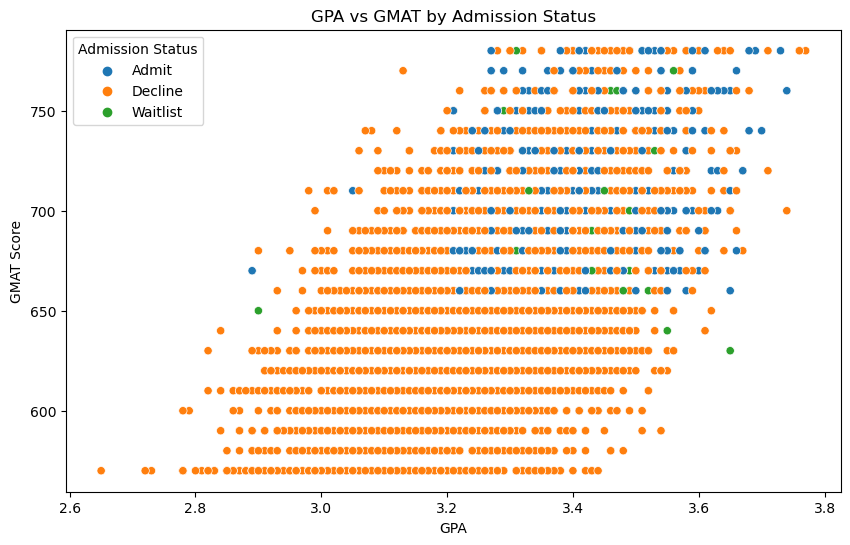

In [13]:
plt.figure(figsize = (10,6))
sns.scatterplot(x='gpa', y='gmat', hue='admission', data=data)
plt.title("GPA vs GMAT by Admission Status")
plt.xlabel("GPA")
plt.ylabel("GMAT Score")
plt.legend(title="Admission Status")
plt.show()

***GPA & GMAT matters!*** This is predictable, especially for a top school like Wharton, having a good academic performance is preferable.

## 2.2 Demographic Distributions

Distribution of Admissions Across Demographics:
admission              Decline     Admit  Waitlist
gender race                                       
Male   Black          0.921875  0.069444  0.008681
       Hispanic       0.906417  0.082888  0.010695
       International  0.869822  0.117498  0.012680
Female Black          0.867647  0.117647  0.014706
Male   Asian          0.855389  0.129604  0.015007
       White          0.854995  0.131042  0.013963
Female Hispanic       0.842342  0.139640  0.018018
Male   Other          0.828767  0.157534  0.013699
Female International  0.766313  0.210926  0.022762
       Asian          0.743961  0.229469  0.026570
       White          0.742857  0.232381  0.024762
       Other          0.725275  0.252747  0.021978


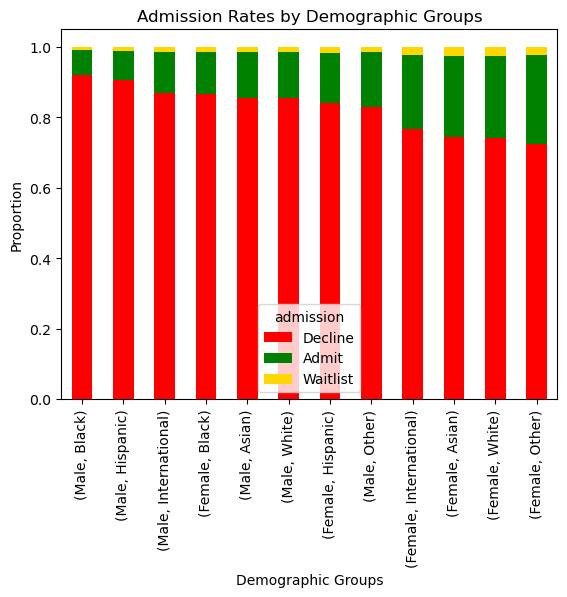

In [25]:
#Distribution of Admissions Across Gender, Race, and International Status (Sorted by Admit)
demo_dist = data.groupby(['gender', 'race'])['admission'].value_counts(normalize=True).unstack()
demo_dist = demo_dist.sort_values(by='Admit', ascending=True)

#Print values
print("Distribution of Admissions Across Demographics:")
print(demo_dist)

# Stacked Bar Plot
demo_dist.plot(
    kind='bar',
    stacked=True,
    color={'Decline': 'red', 'Admit': 'green', 'Waitlist': 'gold'},
    title='Admission Rates by Demographic Groups'
)
plt.ylabel('Proportion')
plt.xlabel('Demographic Groups')
plt.show()

## 2.3 Admissions by Major and Industry

Admission Rates by Undergraduate Major:
major
STEM          0.140267
Business      0.146899
Humanities    0.147924
Name: admission_numeric, dtype: float64


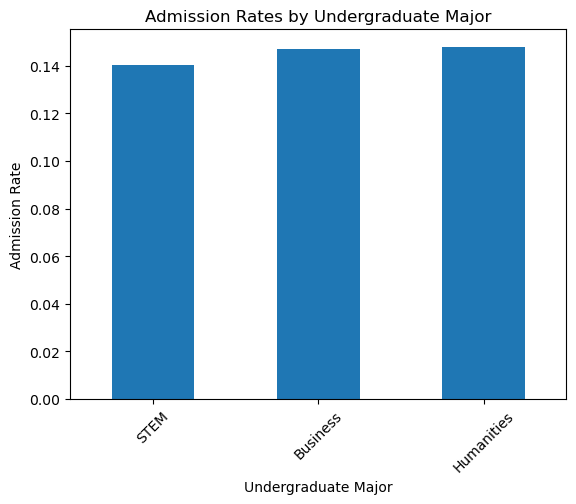

In [26]:
data['admission_numeric'] = pd.to_numeric(data['admission_numeric'], errors='coerce')
admission_rates_by_major = data.groupby('major')['admission_numeric'].mean().sort_values(ascending=True)

# Print admission rates
print("Admission Rates by Undergraduate Major:")
print(admission_rates_by_major)

# Bar plot for Admission Rates by Major
admission_rates_by_major.plot(kind='bar')
plt.title("Admission Rates by Undergraduate Major")
plt.ylabel("Admission Rate")
plt.xlabel("Undergraduate Major")
plt.xticks(rotation = 45)
plt.show()

Admission Rates by Work Industry:
work_industry
Energy                   0.093750
Media/Entertainment      0.118644
Health Care              0.119760
Retail                   0.121212
PE/VC                    0.134509
Other                    0.135392
Nonprofit/Gov            0.136713
Consulting               0.138357
Investment Banking       0.141379
Technology               0.156425
Real Estate              0.162162
CPG                      0.175439
Financial Services       0.190687
Investment Management    0.216867
Name: admission_numeric, dtype: float64


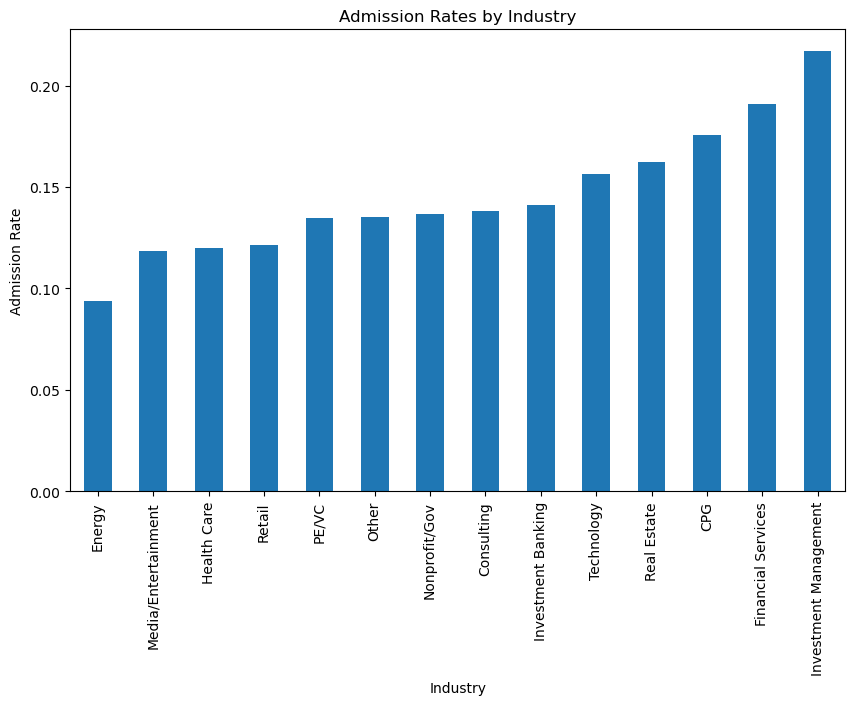

In [27]:
industry_admissions = data.groupby('work_industry')['admission_numeric'].mean().sort_values(ascending=True)

# Print industry admission rates
print("Admission Rates by Work Industry:")
print(industry_admissions)

# Bar plot for Admission Rates by Industry
industry_admissions.plot(kind='bar', figsize=(10, 6))
plt.title("Admission Rates by Industry")
plt.ylabel("Admission Rate")
plt.xlabel("Industry")
plt.show()

## 2.4 Work Experience

***Investigating Impact of Work Experience Ranges on Admission Rates***

Admission Rates by Work Experience Range work_exp_range
0-2 years     0.117647
2-5 years     0.143669
5-10 years    0.149354
Name: admission_numeric, dtype: float64


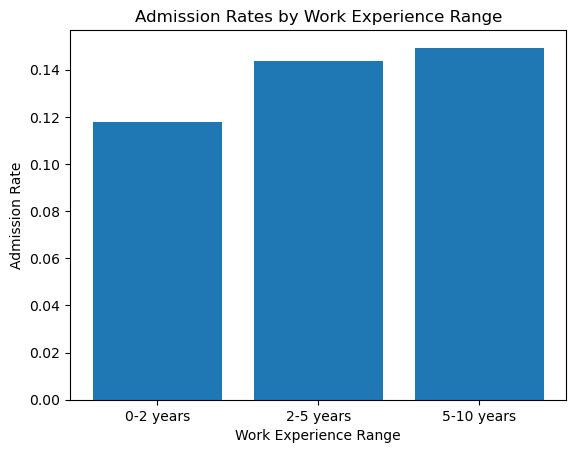

In [28]:
# Define work experience ranges
data['work_exp_range'] = pd.cut(data['work_exp'], bins=[0, 2, 5, 10, 20], labels=['0-2 years', '2-5 years', '5-10 years', '10-20 years'])
data['admission_numeric'] = data['admission_numeric'].astype(float) 
work_exp_admissions = data.groupby(data['work_exp_range'].astype(str))['admission_numeric'].mean()
print("Admission Rates by Work Experience Range", work_exp_admissions)

# Bar plot for work experience ranges
plt.bar(work_exp_admissions.index, work_exp_admissions.values)
plt.title('Admission Rates by Work Experience Range')
plt.xlabel('Work Experience Range')
plt.ylabel('Admission Rate')
plt.show()

# PART 3: STATISTICAL ANALYSES

## 3.1 Correlation Analysis for GPA & GMAT

***Correlation Analysis for GPA & GMAT***

In [29]:
print("Correlation between GPA and Admission (Admitted=1):")
print(data_dummies[['gpa', 'admission_Admit']].corr())

print("Correlation between GMAT and Admission (Admitted=1):")
print(data_dummies[['gmat', 'admission_Admit']].corr())


Correlation between GPA and Admission (Admitted=1):
                      gpa  admission_Admit
gpa              1.000000         0.283404
admission_Admit  0.283404         1.000000
Correlation between GMAT and Admission (Admitted=1):
                     gmat  admission_Admit
gmat             1.000000         0.348319
admission_Admit  0.348319         1.000000


**Analysis:** Both GPA and GMAT are positively correlated with admission status, meaning higher academic performance is associated with higher admission chances. The stronger correlation for GMAT suggests it may weigh more heavily in the admission decision than GPA.

## 3.2 ANOVA Test for Majors

**Null Hypothesis:**
There is no difference in the mean admission rates among applicants with different undergraduate majors

**Alternative Hypothesis:**
At least one major has a significantly different mean admission rate compared to the others

In [30]:
majors = data.groupby('major')['admission_numeric'].apply(list)
f_stat, p_value = f_oneway(*majors)
print("ANOVA F-Statistic:", f_stat, "P-value:", p_value)

ANOVA F-Statistic: 0.2788426266048093 P-value: 0.7566684742600518


**Analysis:** The p-value (0.7127) is much greater than the common significance threshold => fail to reject the null hypothesis, meaning there is no significant difference in admission outcomes across undergraduate majors.

The low F-value suggests that the variance between the groups (undergraduate majors) is not significantly larger than the variance within the groups.

There is no statistically significant difference in admission outcomes across undergraduate majors. The type of undergraduate major does not appear to influence admission decisions in this dataset.


## 3.3 Logistic regression on demographics

**Null Hypothesis:**
Gender and race do not significantly predict the probability of admission

**Alternative Hypothesis:**
At least one demographic variable significantly predicts the probability of admission


In [31]:
features = pd.concat([
    dummies_gender,
    dummies_race     
], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, data_dummies['admission_Admit'], test_size=0.3, random_state=42)

# Logistic Regression with Balanced Class Weight
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train, y_train)

predictions = log_reg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

Logistic Regression Accuracy: 0.6605701990317375
Confusion Matrix:
 [[1087  473]
 [ 158  141]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.70      0.78      1560
         1.0       0.23      0.47      0.31       299

    accuracy                           0.66      1859
   macro avg       0.55      0.58      0.54      1859
weighted avg       0.77      0.66      0.70      1859



**Analysis:** The model suggests that demographic factors like gender and race have some influence on admission outcomes. However, the relatively low precision and recall for the admitted class (1.0) indicate that demographic factors alone may not fully explain admission decisions.

**Feature Importance Analysis**

In [32]:
feature_importance = pd.DataFrame({
    'Feature': features.columns,
    'Coefficient': log_reg.coef_[0]
})
print("\nFeature Importance:\n", feature_importance.sort_values(by='Coefficient', ascending=False))


Feature Importance:
               Feature  Coefficient
6          race_Other     0.369486
0       gender_Female     0.352245
7          race_White     0.208469
2          race_Asian     0.178093
5  race_International     0.052441
4       race_Hispanic    -0.280514
1         gender_Male    -0.338635
3          race_Black    -0.514366


**Race:**

Applicants categorized as race_Other and race_White have the strongest positive impacts on admission likelihood.

race_Black has the most significant negative impact, followed by race_Hispanic.

race_International has a minimal positive impact, suggesting neutrality in admissions for international applicants.

**Gender:**

Being female (gender_Female) is positively associated with admission.

Being male (gender_Male) negatively impacts admission likelihood.
